In [1]:
# Importing libraries

import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import itertools as it
import matplotlib.pyplot as plt

from datetime import datetime
from scipy.stats import multivariate_normal
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

plt.rc('font', size=16)

import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers

# Setting random seed for reproducibility

seed = 42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [2]:
# Opening the dataframe and setting the index
Univariate_data = pd.read_csv('../input/electricity-demand/Univariate_Labeled.csv', parse_dates=['DateTime'])
Univariate_data['DayOfWeek'] = Univariate_data['DateTime'].dt.day_of_week # Introducing the day of the week
Univariate_data.drop(columns='DateTime', inplace=True) # Removing DateTime (we have the day of the week)
Univariate_data = Univariate_data[0:34944] # 52 weeks
Univariate_data

,Consumption,Anomaly,DayOfWeek
0,950.0,0,2
1,939.0,0,2
2,943.0,0,2
3,971.0,0,2
4,1014.0,0,2
...,...,...,...
34939,886.0,0,1
34940,883.0,0,1
34941,868.0,0,1
34942,872.0,0,1


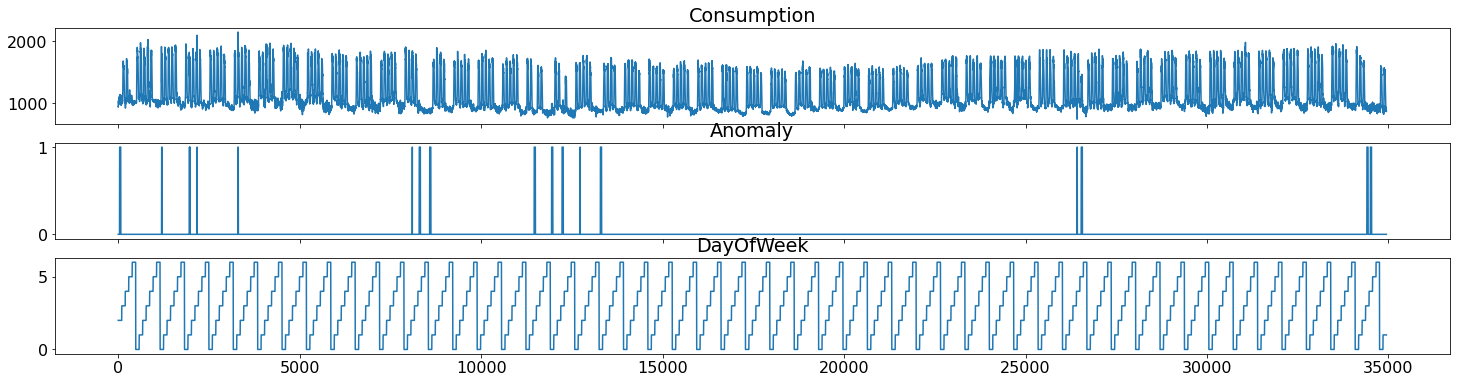

In [3]:
# Function used to plot time series
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(25,6))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()
    
# Plotting time series
inspect_dataframe(Univariate_data, Univariate_data.columns)

In [4]:
# Columns used for the following split in train, test and validation sets
Univariate_data['Test'] = 0
Univariate_data['Validation'] = 0
Univariate_data['Train_P1'] = 0
Univariate_data['Train_P2'] = 0
Univariate_data['Train_P3'] = 0
Univariate_data

,Consumption,Anomaly,DayOfWeek,Test,Validation,Train_P1,Train_P2,Train_P3
0,950.0,0,2,0,0,0,0,0
1,939.0,0,2,0,0,0,0,0
2,943.0,0,2,0,0,0,0,0
3,971.0,0,2,0,0,0,0,0
4,1014.0,0,2,0,0,0,0,0
...,...,...,...,...,...,...,...,...
34939,886.0,0,1,0,0,0,0,0
34940,883.0,0,1,0,0,0,0,0
34941,868.0,0,1,0,0,0,0,0
34942,872.0,0,1,0,0,0,0,0


In [5]:
# TEST SET

# Weeks containing anomalies
for i in range (52):
    Slice_Univariate_data = Univariate_data.iloc[(i)*672:(i+1)*672]
    if(Slice_Univariate_data['Anomaly'].sum() != 0):
        Univariate_data.iloc[(i)*672:(i+1)*672]['Test'] = 1

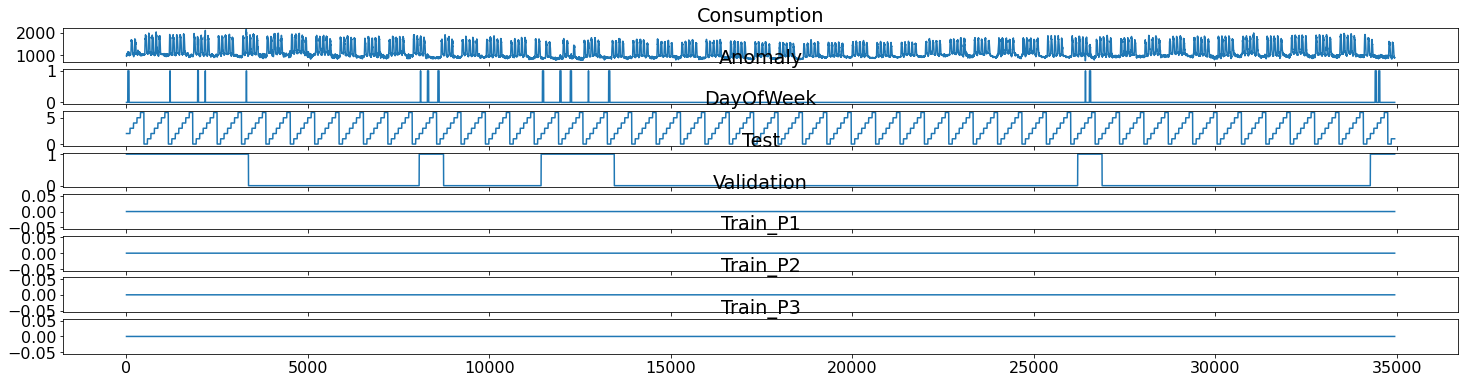

In [6]:
# Plotting time series
inspect_dataframe(Univariate_data, Univariate_data.columns)

In [7]:
# VALIDATION SET

# Some random weeks (without anomalies)
week = [40,41,42,43,44,45,46,47,48,49,50]
for j in week:
    Slice_Univariate_data = Univariate_data.iloc[(j)*672:(j+1)*672]
    Univariate_data.iloc[(j)*672:(j+1)*672]['Validation'] = 1

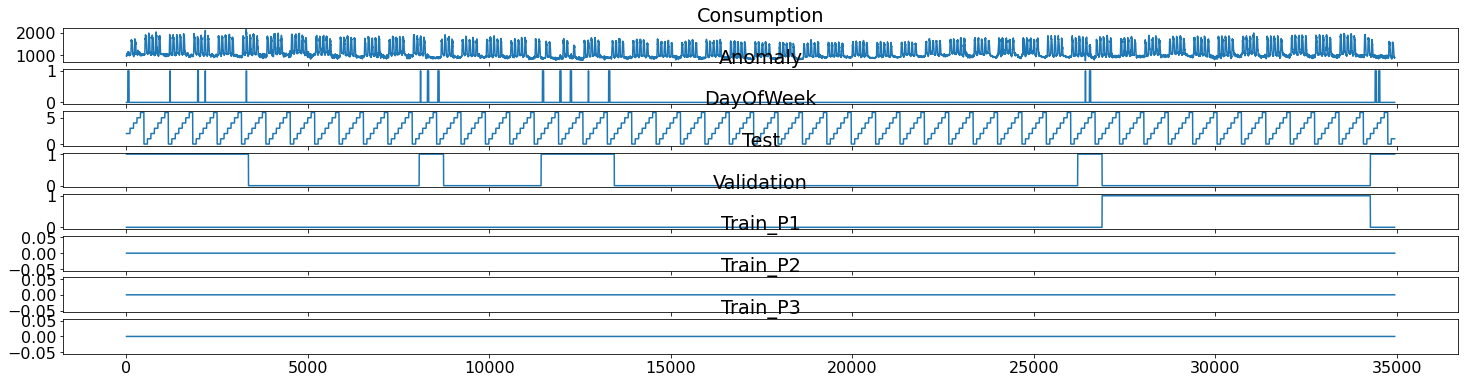

In [8]:
# Plotting time series
inspect_dataframe(Univariate_data, Univariate_data.columns)

In [9]:
# TRAINING SET (3 sets to respect the sequentiality of weeks)

week = [5,6,7,8,9,10,11]
for j in week:
    Slice_Univariate_data = Univariate_data.iloc[(j)*672:(j+1)*672]
    Univariate_data.iloc[(j)*672:(j+1)*672]['Train_P1'] = 1
    
week = [13,14,15,16]
for j in week:
    Slice_Univariate_data = Univariate_data.iloc[(j)*672:(j+1)*672]
    Univariate_data.iloc[(j)*672:(j+1)*672]['Train_P2'] = 1
    
week = [20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38]
for j in week:
    Slice_Univariate_data = Univariate_data.iloc[(j)*672:(j+1)*672]
    Univariate_data.iloc[(j)*672:(j+1)*672]['Train_P3'] = 1

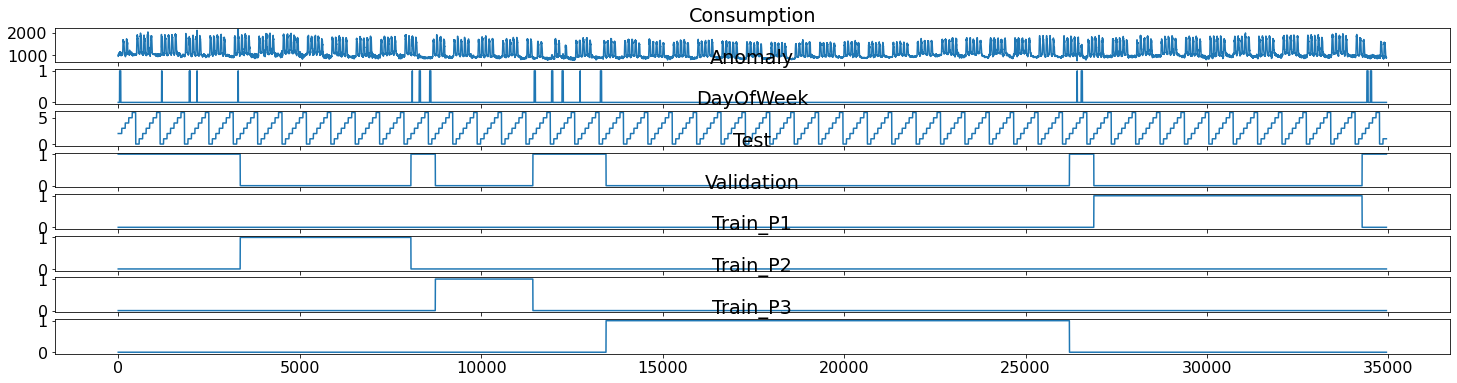

In [10]:
# Plotting time series
inspect_dataframe(Univariate_data, Univariate_data.columns)

In [11]:
# TRAIN, TEST, VALIDATION SETS
X_train_temp_P1 = Univariate_data[Univariate_data['Train_P1']==1].copy()
X_train_temp_P2 = Univariate_data[Univariate_data['Train_P2']==1].copy()
X_train_temp_P3 = Univariate_data[Univariate_data['Train_P3']==1].copy()
X_validation_temp = Univariate_data[Univariate_data['Validation']==1].copy()
X_test_temp = Univariate_data[Univariate_data['Test']==1].copy()

In [12]:
# Training, Validation and Test set - Anomalies (not used for training)
Anomaly_Train_P1 = X_train_temp_P1[['Anomaly']]
Anomaly_Train_P2 = X_train_temp_P2[['Anomaly']]
Anomaly_Train_P3 = X_train_temp_P3[['Anomaly']]
Anomaly_Validation = X_validation_temp[['Anomaly']]
Anomaly_Test = X_test_temp[['Anomaly']]

In [13]:
temp = pd.concat([X_train_temp_P1,X_train_temp_P2],axis=0)
X_train_temp_global = pd.concat([X_train_temp_P3,temp],axis=0)
X_train_temp_global.shape

(20160, 8)

In [14]:
# STANDARDIZATION

mean = X_train_temp_global.mean()
std_dev = X_train_temp_global.std()
print(mean, std_dev)

X_train_raw_P1 = (X_train_temp_P1-mean)/std_dev
X_train_raw_P2 = (X_train_temp_P2-mean)/std_dev
X_train_raw_P3 = (X_train_temp_P3-mean)/std_dev
X_validation_raw = (X_validation_temp-mean)/std_dev
X_test_raw = (X_test_temp-mean)/std_dev

print(X_test_raw.shape[0]+X_validation_raw.shape[0]+X_train_raw_P1.shape[0]+X_train_raw_P2.shape[0]+X_train_raw_P3.shape[0] == Univariate_data.shape[0])

Consumption    1136.788542
Anomaly           0.000000
DayOfWeek         3.000000
Test              0.000000
Validation        0.000000
Train_P1          0.233333
Train_P2          0.133333
Train_P3          0.633333
dtype: float64 Consumption    282.830237
Anomaly          0.000000
DayOfWeek        2.000050
Test             0.000000
Validation       0.000000
Train_P1         0.422963
Train_P2         0.339943
Train_P3         0.481906
dtype: float64
True


In [15]:
# Anomalies are not considered during the training
X_train_raw_P1 = X_train_raw_P1[['Consumption', 'DayOfWeek']]
X_train_raw_P2 = X_train_raw_P2[['Consumption', 'DayOfWeek']]
X_train_raw_P3 = X_train_raw_P3[['Consumption', 'DayOfWeek']]
X_validation_raw = X_validation_raw[['Consumption', 'DayOfWeek']]
X_test_raw = X_test_raw[['Consumption', 'DayOfWeek']]
X_train_raw_P1.shape, X_train_raw_P2.shape, X_train_raw_P3.shape, X_validation_raw.shape, X_test_raw.shape

((4704, 2), (2688, 2), (12768, 2), (7392, 2), (7392, 2))

In [16]:
X_train_raw_P1.reset_index(inplace=True)
X_train_raw_P1.drop(columns='index', inplace=True)
X_train_raw_P2.reset_index(inplace=True)
X_train_raw_P2.drop(columns='index', inplace=True)
X_train_raw_P3.reset_index(inplace=True)
X_train_raw_P3.drop(columns='index', inplace=True)
X_validation_raw.reset_index(inplace=True)
X_validation_raw.drop(columns='index', inplace=True)
X_test_raw.reset_index(inplace=True)
X_test_raw.drop(columns='index', inplace=True)

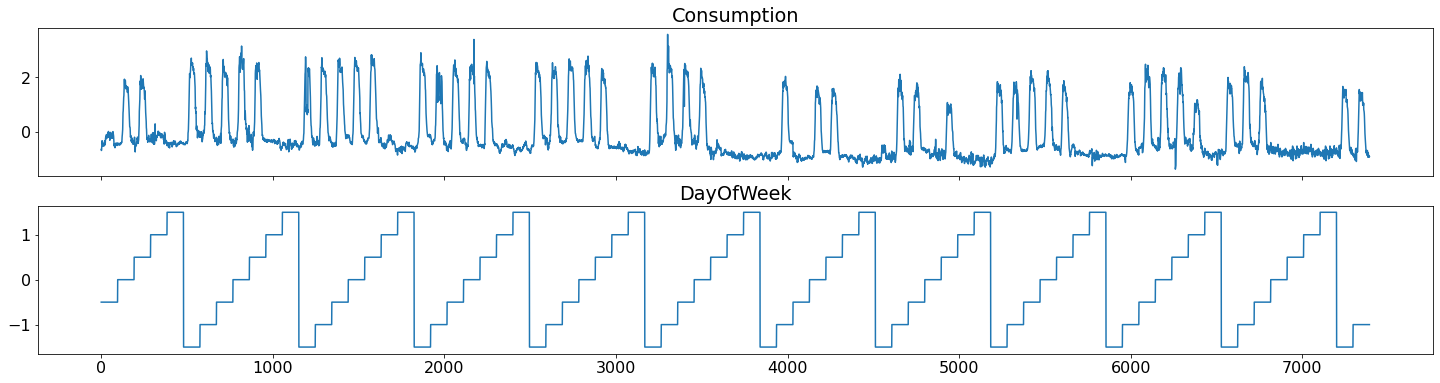

In [17]:
# Plotting time series
inspect_dataframe(X_test_raw, X_test_raw.columns)

## Training Preparation

In [18]:
# Training parameters

window = 672       # 1 week
stride = 4         # 1 hour
latent_dim = 6     # Latent dimension
epochs = 150       # Number of epochs (no early stopping)
batch_size = 8     # Batch size
f = 7              # Filters' dimensions

In [19]:
# Function used to create (overlapped) windows that we will use for the training
def build_sequences(df, anomaly, window=window, stride=stride):
    
    assert len(df) > window
    dataset = []
    anomalies = []
    temp_df = df.copy().values
    temp_an = anomaly.copy().values
    padding_len = (len(df)-window)%stride # Padding computed considering the stride
    print("PADDING: " + str(padding_len)) #DEBUG

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float32')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_an.shape[1]), dtype='float32')
        temp_an = np.concatenate((padding,temp_an))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window+1,stride):
        dataset.append(temp_df[idx:idx+window])
        anomalies.append(temp_an[idx:idx+window])

    dataset = np.array(dataset)
    anomalies = np.array(anomalies)
    return dataset, anomalies

In [20]:
X_train_P1, A_train_P1 = build_sequences(X_train_raw_P1, Anomaly_Train_P1, window=window, stride=stride)
X_train_P2, A_train_P2 = build_sequences(X_train_raw_P2, Anomaly_Train_P2, window=window, stride=stride)
X_train_P3, A_train_P3 = build_sequences(X_train_raw_P3, Anomaly_Train_P3, window=window, stride=stride)
X_val, A_val = build_sequences(X_validation_raw, Anomaly_Validation, window=window, stride=stride)
X_train_P1.shape,X_train_P2.shape,X_train_P3.shape

PADDING: 0
PADDING: 0
PADDING: 0
PADDING: 0


((1009, 672, 2), (505, 672, 2), (3025, 672, 2))

In [21]:
X_train = np.concatenate([X_train_P1,X_train_P2],axis=0)
X_train = np.concatenate([X_train,X_train_P3],axis=0)
A_train = np.concatenate([A_train_P1,A_train_P2],axis=0)
A_train = np.concatenate([A_train,A_train_P3],axis=0)
X_train.shape, A_train.shape

((4539, 672, 2), (4539, 672, 1))

## Building the model + Training

In [22]:
# Building the model

input_shape = X_train.shape[1:]
output_shape = X_train.shape[1:]

#Encoder
encoder_input = tf.keras.Input(shape=input_shape)

x = tfkl.Conv1D(16, f, activation="relu", strides=1, padding="same")(encoder_input)
x = tfkl.MaxPool1D(pool_size=2, strides=2)(x)
x = tfkl.Conv1D(32, f, activation="relu", strides=1, padding="same")(x)
x = tfkl.MaxPool1D(pool_size=2, strides=2)(x)
x = tfkl.Conv1D(64, f, activation="relu", strides=1, padding="same")(x)
x = tfkl.MaxPool1D(pool_size=2, strides=2)(x)

x = tfkl.Flatten()(x)
x = tfkl.Dense(latent_dim, activation='linear')(x)

#Decoder
x = tfkl.Dense(units=42*X_train.shape[2])(x)
x = tfkl.Reshape((42,X_train.shape[2]))(x)
x = tfkl.Conv1DTranspose(64,f,2, padding='same', activation='relu')(x)
x = tfkl.Conv1DTranspose(32,f,2, padding='same', activation='relu')(x)
x = tfkl.Conv1DTranspose(16,f,2, padding='same', activation='relu')(x)
decoder_output = tfkl.Conv1DTranspose(X_train.shape[2],f,2, padding='same', activation='linear')(x)

#Model
autoencoder = tfk.Model(inputs=encoder_input, outputs=decoder_output, name='Autoencoder')
autoencoder.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=[tfk.metrics.MeanSquaredError()])
autoencoder.summary()

2022-08-05 13:58:11.877843: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "Autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 672, 2)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 672, 16)           240       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 336, 16)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 336, 32)           3616      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 168, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 168, 64)           14400     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 84, 64)            

In [23]:
# Training
history = autoencoder.fit(
    X_train,
    X_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data = (X_val,X_val),
    callbacks=[
        tfk.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-5),
    ]
).history

2022-08-05 13:58:12.349433: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/150
568/568 [==============================] - 12s 18ms/step - loss: 0.2792 - mean_squared_error: 0.2792 - val_loss: 0.0905 - val_mean_squared_error: 0.0905
Epoch 2/150
568/568 [==============================] - 10s 18ms/step - loss: 0.0637 - mean_squared_error: 0.0637 - val_loss: 0.0616 - val_mean_squared_error: 0.0616
Epoch 3/150
568/568 [==============================] - 10s 18ms/step - loss: 0.0498 - mean_squared_error: 0.0498 - val_loss: 0.0495 - val_mean_squared_error: 0.0495
Epoch 4/150
568/568 [==============================] - 11s 19ms/step - loss: 0.0427 - mean_squared_error: 0.0427 - val_loss: 0.0429 - val_mean_squared_error: 0.0429
Epoch 5/150
568/568 [==============================] - 10s 18ms/step - loss: 0.0386 - mean_squared_error: 0.0386 - val_loss: 0.0413 - val_mean_squared_error: 0.0413
Epoch 6/150
568/568 [==============================] - 10s 18ms/step - loss: 0.0369 - mean_squared_error: 0.0369 - val_loss: 0.0412 - val_mean_squared_error: 0.0412
Epoch 7/15

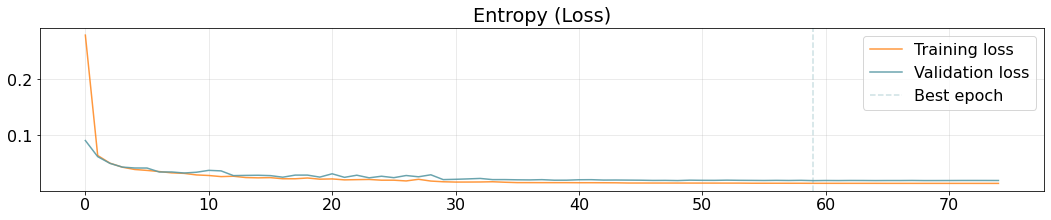

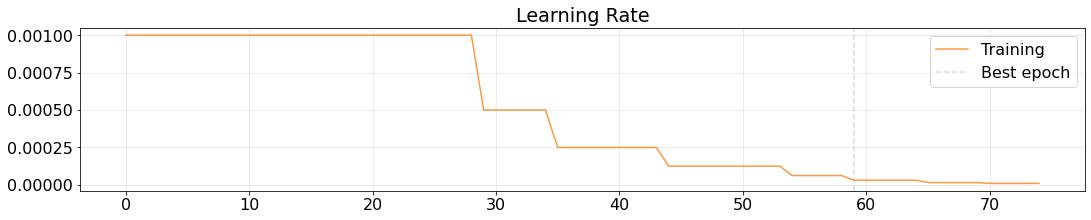

In [24]:
# Plotting info on the training

best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(18,3))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Entropy (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Training', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Learning Rate')
plt.legend()
plt.grid(alpha=.3)
plt.show()

## Example of prediction on the test set

In [25]:
# Function used to plot time series
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(30,20))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()

In [26]:
# Example of prediction on the test set
i = 0
j = 1
Univariate_print = X_test_raw.iloc[i*672:j*672].copy()
X = np.expand_dims(Univariate_print, axis=0)
prediction = autoencoder.predict(X)
prediction.shape

(1, 672, 2)

In [27]:
# Adding anomalies to the plot (not used during training)
anomaly = X_test_temp['Anomaly'].iloc[i*672:j*672].copy()

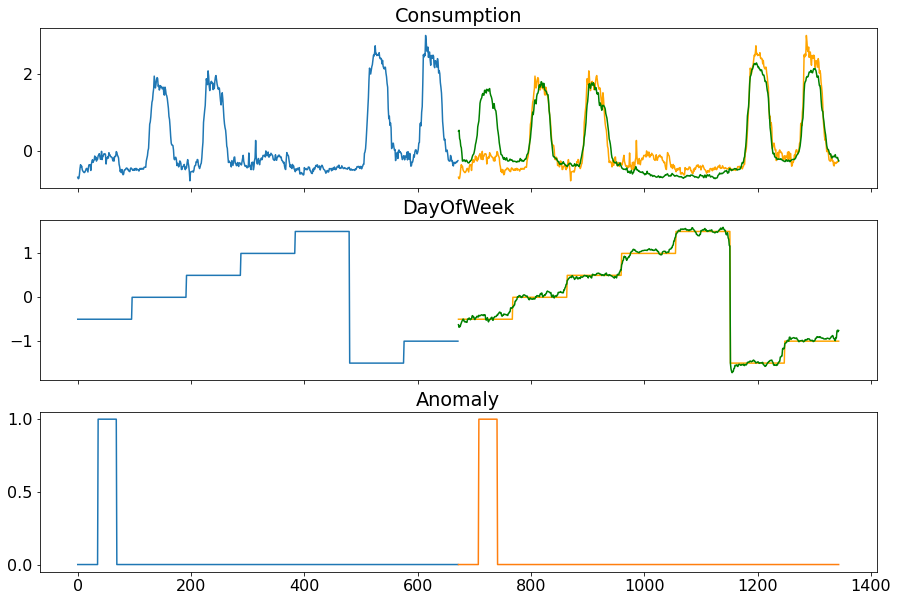

In [28]:
# Function to plot expected values and predicted values
target_labels = X_test_raw.columns

def inspect_multivariate_prediction(X, y, a, pred, columns): 
   
    figs, axs = plt.subplots(3, 1, sharex=True, figsize=(15,10)) 
    for i, col in enumerate(columns[:4]): 
        axs[i].plot(np.arange(len(X[0,:,i])), X[0,:,i]) 
        axs[i].plot(np.arange(len(X[0,:,i]), len(X[0,:,i])*2), y[0,:,i], color='orange') 
        axs[i].plot(np.arange(len(X[0,:,i]), len(X[0,:,i])*2), pred[0,:,i], color='green') 
        axs[i].set_title(col) 
            
    axs[2].plot(np.arange(len(X[0,:,i])), a) 
    axs[2].plot(np.arange(len(X[0,:,i]), len(X[0,:,i])*2), a) 
    axs[2].set_title('Anomaly') 
    plt.show()
    
# Plotting predictions
inspect_multivariate_prediction(X, X, anomaly, prediction, target_labels)

## Computing reconstruction error

In [29]:
# Function used to create non-overlapped windows starting from the TRAINING set
def build_sequences_reconstruction(df, window, stride):
    dataset = []
    temp_df = df.copy().values
    padding_len = (len(df)-window)%stride

    for idx in np.arange(0,len(temp_df)-window+1,stride):
        dataset.append(temp_df[idx:idx+window])

    dataset = np.array(dataset)
    return dataset

In [30]:
# Non overlapped windows - Training set
X_train_non_overlapped_P1 = build_sequences_reconstruction(X_train_raw_P1, window=window, stride=window)
X_train_non_overlapped_P2 = build_sequences_reconstruction(X_train_raw_P2, window=window, stride=window)
X_train_non_overlapped_P3 = build_sequences_reconstruction(X_train_raw_P3, window=window, stride=window)

X_train_non_overlapped = np.concatenate([X_train_non_overlapped_P1,X_train_non_overlapped_P2],axis=0)
X_train_non_overlapped = np.concatenate([X_train_non_overlapped,X_train_non_overlapped_P3],axis=0)

X_train_non_overlapped.shape

(30, 672, 2)

In [31]:
test_weeks = [0,1,2,3,4,12,17,18,19,39,51] # Weeks that are in the test set
indexes = [0,5,6,9,10] # Considering positions in "text_weeks", indexes of weeks to be considered on alone (non consecutive)
full_seq_index = [] # Tells us which windows of X_Test_Overlapped have to be fully considered (for all the other windows we will consider last "stride" elements)

counter = 0 # Tells us which window of X_Test_Overlapped we're considering

X_test_overlapped = np.empty(shape=(0, 672, 2))

for i in range(len(indexes)): # For all windows to be considered on alone ...
    
    # Interval of consecutive weeks to be considered
    left = indexes[i]
    if i+1 < len(indexes):
        right = indexes[i+1]
    else:
        right = indexes[-1] + 1
    
    full_seq_index.append(counter)
    df = X_test_raw.iloc[(left)*672:(right)*672].copy()
    dataset = build_sequences_reconstruction(df, window, stride) # Creating sequences using consecutive weeks we have identified
    counter = counter + dataset.shape[0]
    X_test_overlapped = np.concatenate((X_test_overlapped, dataset[:,:,:2]), axis=0) # We concatenate new windows created
        
X_test_overlapped.shape, full_seq_index

((1013, 672, 2), [0, 673, 674, 1011, 1012])

In [32]:
# Making predictions on non-overlapped windows of the training set
train_reconstructions = autoencoder.predict(X_train_non_overlapped)
train_reconstructions.shape

(30, 672, 2)

In [33]:
# Making predictions on overlapped windows of the test set
test_reconstructions = autoencoder.predict(X_test_overlapped)
test_reconstructions.shape

(1013, 672, 2)

In [34]:
# Function used to plot predictions (reconstructions) made on training data using the model
def inspect_multivariate_prediction_reconstruction(X, y, a, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(pred))
        print('Plotting sequence number: ' + str(idx))

    figs, axs = plt.subplots(2, 1, sharex=True, figsize=(17,7))
    for i, col in enumerate(columns[:4]):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].plot(np.arange(len(X[0,:,i]), len(X[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].plot(np.arange(len(X[0,:,i]), len(X[0,:,i])+telescope), pred[idx,:,i], color='green')
        axs[i].set_title(col)
    plt.show()

Plotting sequence number: 6


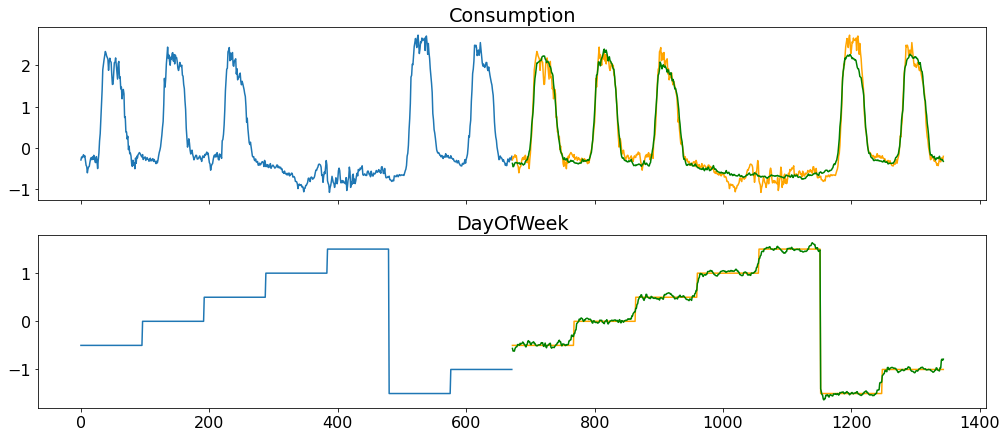

In [35]:
# Plotting reconstructions of the TRAINING set
inspect_multivariate_prediction_reconstruction(X_train_non_overlapped, X_train_non_overlapped, A_train, train_reconstructions, target_labels, window)

In [36]:
# Array that will contain reconstruction errors (floor by floor) - TRAINING SET
reconstruction_errors = np.empty(shape=(0, 1))

# Computing reconstruction errors
for i in range(X_train_non_overlapped.shape[0]):
    error = np.abs(X_train_non_overlapped[i]-train_reconstructions[i])
    error = error[:,:1] # Not interested in the day of the week
    reconstruction_errors = np.concatenate((reconstruction_errors,error), axis=0)
    
mean_error = np.mean(reconstruction_errors, axis = 0) # Mean reconstruction error
std_error = np.std(reconstruction_errors, axis = 0) # Std dev of the reconstruction error
max_error = np.max(reconstruction_errors, axis = 0) # Max error on the training set
  
print(reconstruction_errors.shape)
print(mean_error)
print(std_error)
print(max_error)

(20160, 1)
[0.11649564]
[0.09887832]
[1.00885414]


In [37]:
# Function used to predict anomalies
def predict_anomalies(reconstruction_errors, error_threshold):
    
    # Inizially we don't have predicted anomalies
    anomaly_predicted = np.zeros(shape=(X_test_raw.shape[0]))
    
    i = 0
    for seq in reconstruction_errors:
        for sample in seq: 
            epsilon = sample - error_threshold # We check if the reconstruction error is greater than the threshold
            if epsilon > 0:
                anomaly_predicted[i] = 1
            i = i+1

    return anomaly_predicted

In [38]:
# Array that will contain reconstruction errors (floor by floor) - TEST SET

reconstruction_test = np.empty(shape=(0, 1)) # Predictions made on the test set using the model
reconstruction_errors_test = np.empty(shape=(0, 1)) # Errors made in predicting the test set

for i in range(X_test_overlapped.shape[0]):
    if i in full_seq_index: # Windows to be entirely considered
        error = np.abs(X_test_overlapped[i]-test_reconstructions[i])
        error = error[:,:1] # Not interested in the day of the week
        reconstruction_errors_test = np.concatenate((reconstruction_errors_test,error), axis=0)
        reconstruction_test = np.concatenate((reconstruction_test, test_reconstructions[i,:,:1]), axis=0)
    else: # Windows for which we have to consider only last "stride" elements
        error = np.abs(X_test_overlapped[i,-stride:,:]-test_reconstructions[i,-stride:,:])
        error = error[:,:1] # Not interested in the day of the week
        reconstruction_errors_test = np.concatenate((reconstruction_errors_test,error), axis=0)
        reconstruction_test = np.concatenate((reconstruction_test, test_reconstructions[i,-stride:,:1]), axis=0)
                                        
print(reconstruction_errors_test.shape)
print(reconstruction_test.shape)

(7392, 1)
(7392, 1)


In [39]:
# Grid search threshold parameters

range_of_val = [x for x in np.arange(2, 11, 0.1)]
best_val = 0
F1_MAX = 0

for i in range_of_val:
    threshold_error_mean_std_TEMP = 0
    threshold_error_mean_std_TEMP = mean_error + i*std_error # mean + n*std_dev
    anomaly_predicted_mean_std_TEMP = 0
    anomaly_predicted_mean_std_TEMP = predict_anomalies(reconstruction_errors_test, threshold_error_mean_std_TEMP)
    f1 = f1_score(y_true=Anomaly_Test, y_pred=anomaly_predicted_mean_std_TEMP)
    if(f1>F1_MAX):
        F1_MAX = f1
        best_val = i
        print("best threshold parameters: " + str(best_val) + " best f1: " + str(F1_MAX))
            
threshold_error_mean_std = mean_error + best_val*std_error # mean + n*std_dev
anomaly_predicted_mean_std = predict_anomalies(reconstruction_errors_test, threshold_error_mean_std)
                
threshold_error_max = max_error # Max error on the training set
anomaly_predicted_max = predict_anomalies(reconstruction_errors_test, threshold_error_max)

anomaly_predicted_mean_std.sum(), anomaly_predicted_max.sum(), anomaly_predicted_mean_std.shape, anomaly_predicted_max.shape, threshold_error_mean_std, threshold_error_max

best threshold parameters: 2.0 best f1: 0.3331824354911725
best threshold parameters: 2.1 best f1: 0.3424848766868311
best threshold parameters: 2.2 best f1: 0.3511450381679389
best threshold parameters: 2.3000000000000003 best f1: 0.359375
best threshold parameters: 2.4000000000000004 best f1: 0.368
best threshold parameters: 2.5000000000000004 best f1: 0.37641025641025644
best threshold parameters: 2.6000000000000005 best f1: 0.385099685204617
best threshold parameters: 2.7000000000000006 best f1: 0.3927233814874264
best threshold parameters: 2.8000000000000007 best f1: 0.4050772626931567
best threshold parameters: 2.900000000000001 best f1: 0.4135211267605633
best threshold parameters: 3.000000000000001 best f1: 0.4223889209463358
best threshold parameters: 3.100000000000001 best f1: 0.4313494401885681
best threshold parameters: 3.200000000000001 best f1: 0.44108761329305135
best threshold parameters: 3.300000000000001 best f1: 0.45161290322580644
best threshold parameters: 3.400000

(404.0, 396.0, (7392,), (7392,), array([0.99651267]), array([1.00885414]))

In [40]:
padding_len = (len(X_test_raw)-window)%stride
size = X_test_raw.shape[0]-padding_len
X_test_raw = X_test_raw[:size]

In [41]:
Anomaly_Test.reset_index(inplace=True)
Anomaly_Test.drop(columns='index', inplace=True)

In [42]:
# Adding ptdictions and predicted anomalies to X_test_raw
X_test_raw['Reconstr'] = reconstruction_test[:,0] # Prediction on floor 1
X_test_raw['Anomaly_Label_GT'] = Anomaly_Test # Ground truth anomalies
X_test_raw['Anomaly_Predicted_Mean_Std'] = anomaly_predicted_mean_std[:X_test_raw.shape[0]] # Anomalies predicted using mean and std dev
X_test_raw['Anomaly_Predicted_Max'] = anomaly_predicted_max[:X_test_raw.shape[0]] # Anomalies predicted using max error on the training set
X_test_raw['Error'] = reconstruction_errors_test[:,0] # Prediction error on floor 1
X_test_raw.head()

import datetime as dt

X = np.array(X_test_raw.iloc[:672][['Consumption']])
predictions = np.array(X_test_raw.iloc[:672][['Reconstr']])
anomaly_true = X_test_raw.iloc[:672]['Anomaly_Label_GT']
anomaly_prediction_mean_std_dev = X_test_raw.iloc[:672]['Anomaly_Predicted_Mean_Std']
anomaly_prediction_max = X_test_raw.iloc[:672]['Anomaly_Predicted_Max']
error_1F = X_test_raw.iloc[:672]['Error']

In [43]:
# Function used to plot time series
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(30,20))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()

In [44]:
import datetime as dt

i=4
j=i+3

X = np.array(X_test_raw.iloc[i*672:j*672][['Consumption']])
predictions = np.array(X_test_raw.iloc[i*672:j*672][['Reconstr']])
anomaly_true = X_test_raw.iloc[i*672:j*672]['Anomaly_Label_GT']
anomaly_prediction_mean_std_dev = X_test_raw.iloc[i*672:j*672]['Anomaly_Predicted_Mean_Std']
anomaly_prediction_max = X_test_raw.iloc[i*672:j*672]['Anomaly_Predicted_Max']
error_1F = X_test_raw.iloc[i*672:j*672]['Error']

In [45]:
def inspect_multivariate_prediction(X, y, a_true, a_predicted_mean_std, a_predicted_max, pred, columns, error_1F): 
   
    figs, axs = plt.subplots(5, 1, sharex=True, figsize=(17,17)) 
    for i, col in enumerate(columns[:1]): 
        axs[i].plot(np.arange(len(X[:,i])), X[:,i]) 
        axs[i].plot(np.arange(len(X[:,i]), len(X[:,i])*2), y[:,i], color='orange') 
        axs[i].plot(np.arange(len(X[:,i]), len(X[:,i])*2), pred[:,i], color='green') 
        axs[i].set_title(col) 
        
    axs[1].plot(np.arange(len(X[:,i])), error_1F) 
    axs[1].plot(np.arange(len(X[:,i]), len(X[:,i])*2), error_1F) 
    axs[1].set_title('error') 
            
    axs[2].plot(np.arange(len(X[:,i])), a_true) 
    axs[2].plot(np.arange(len(X[:,i]), len(X[:,i])*2), a_true) 
    axs[2].set_title('Anomaly_True') 
    
    axs[3].plot(np.arange(len(X[:,i])), a_predicted_mean_std) 
    axs[3].plot(np.arange(len(X[:,i]), len(X[:,i])*2), a_predicted_mean_std) 
    axs[3].set_title('Anomaly_Predicted_Mean_Std_Dev')
    
    axs[4].plot(np.arange(len(X[:,i])), a_predicted_max) 
    axs[4].plot(np.arange(len(X[:,i]), len(X[:,i])*2), a_predicted_max) 
    axs[4].set_title('Anomaly_Predicted_Max') 
    plt.show()

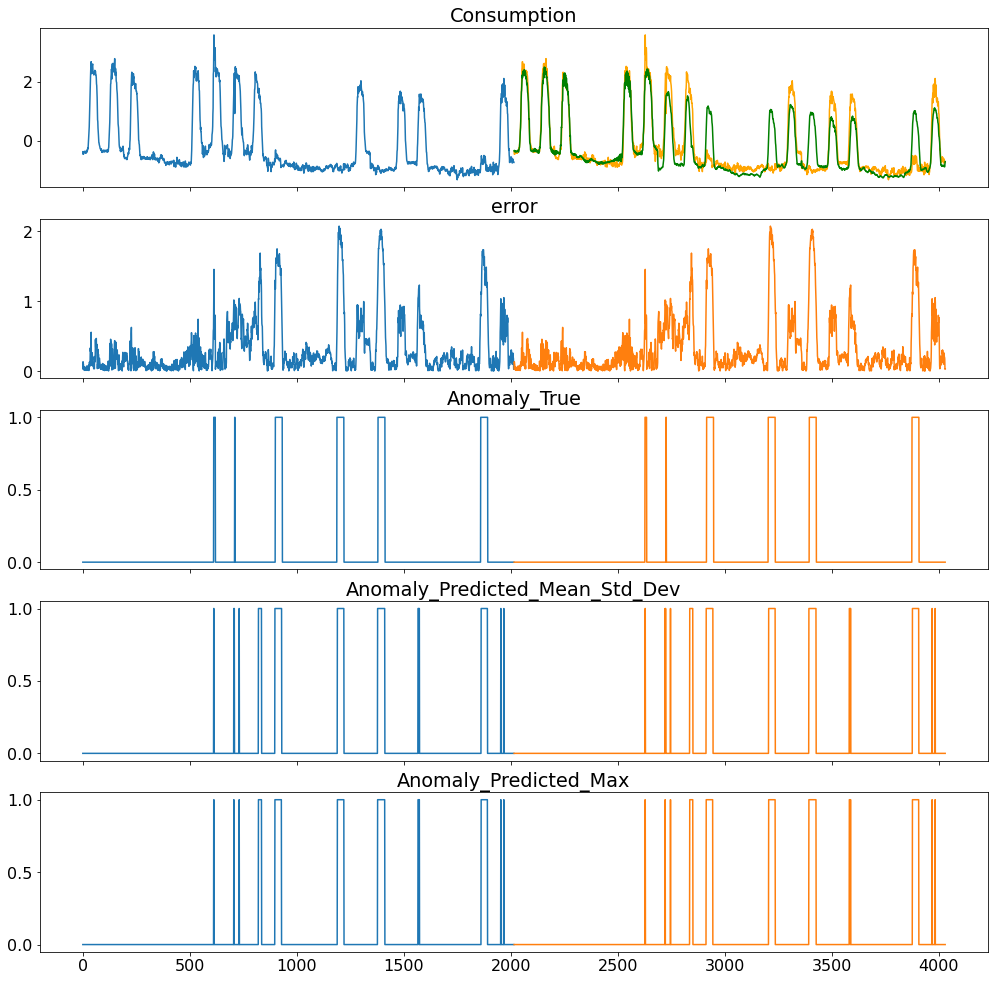

In [46]:
# Plotting predictions
inspect_multivariate_prediction(X, X, anomaly_true, anomaly_prediction_mean_std_dev, anomaly_prediction_max, predictions, target_labels, error_1F) # X = ABB_print

Accuracy: 0.9815
Precision: 0.7896
Recall: 0.8598
F1: 0.8232


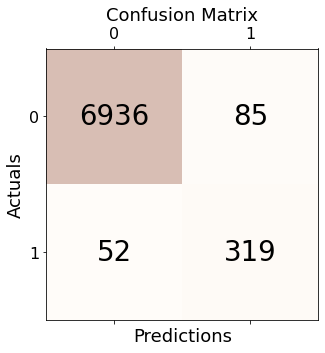

In [47]:
anomaly_predicted = anomaly_predicted_mean_std

# Compute the confusion matrix
cm = confusion_matrix(y_true=Anomaly_Test, y_pred=anomaly_predicted)

# Compute the classification metrics
accuracy = accuracy_score(y_true=Anomaly_Test, y_pred=anomaly_predicted)
precision = precision_score(y_true=Anomaly_Test, y_pred=anomaly_predicted)
recall = recall_score(y_true=Anomaly_Test, y_pred=anomaly_predicted)
f1 = f1_score(y_true=Anomaly_Test, y_pred=anomaly_predicted)
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(cm, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')
        
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

Accuracy: 0.9812
Precision: 0.7929
Recall: 0.8464
F1: 0.8188


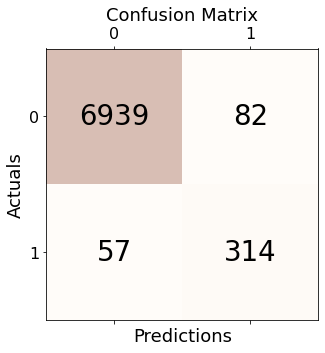

In [48]:
anomaly_predicted = anomaly_predicted_max

# Compute the confusion matrix
cm = confusion_matrix(y_true=Anomaly_Test, y_pred=anomaly_predicted)

# Compute the classification metrics
accuracy = accuracy_score(y_true=Anomaly_Test, y_pred=anomaly_predicted)
precision = precision_score(y_true=Anomaly_Test, y_pred=anomaly_predicted)
recall = recall_score(y_true=Anomaly_Test, y_pred=anomaly_predicted)
f1 = f1_score(y_true=Anomaly_Test, y_pred=anomaly_predicted)
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(cm, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')
        
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()